<a href="https://colab.research.google.com/github/ElijahWandimi/Datascience/blob/main/Image_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the needed libraries
import os
import shutil
import numpy as np # numerical computing
from PIL import Image # imaging
import matplotlib.pyplot as plt # visualisation

# deep learning
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.manifold import TSNE

from google.colab import files
import warnings
warnings.filterwarnings("ignore")


#### downloading data
cooncect kaggle and colab to load data directly inot colab

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elijahwandimi","key":"40b6eb8cdd5bfac1801244bff2153222"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sundarannamalai/hair-diseases

 99% 559M/564M [00:18<00:00, 39.5MB/s]
100% 564M/564M [00:18<00:00, 32.3MB/s]


In [5]:
! mkdir hair_diseases
! unzip -q hair-diseases.zip -d hair_diseases
! mkdir Diseases

#### Create data folder with Alopecia Areata as the positive class

In [7]:
diseases_dir = '/content/Diseases'
source_dir_al = "/content/hair_diseases/Hair Diseases - Final/train/Alopecia Areata"
source_dir_other = '/content/hair_diseases/Hair Diseases - Final/train/'
destination_dir_other = "/content/Diseases/other"
destination_dir_al = '/content/Diseases/Alopecia Areata'

# Create the "other" directory if it doesn't exist
if not os.path.exists(destination_dir_al):
    os.makedirs(destination_dir_al)
    print("Directory 'Alopecia Areata' created successfully.")

# Loop through the source directory and its subdirectories
for root, _, files in os.walk(source_dir_al):
    for file_name in files:
        source_file_path = os.path.join(root, file_name)
        destination_file_path = os.path.join(destination_dir_al, file_name)

        # Copy the file to the destination directory
        shutil.move(source_file_path, destination_file_path)
    os.rmdir(source_dir_al)
    print(f"Copied all files to 'Diseases/Alopecia Areate' folder.")

if not os.path.exists(destination_dir_other):
    os.makedirs(destination_dir_other)
    print("Directory 'other' created successfully.")

for root, _, files in os.walk(source_dir_other):
    for file_name in files:
        source_file_path = os.path.join(root, file_name)
        destination_file_path = os.path.join(destination_dir_other, file_name)

        # Copy the file to the destination directory
        shutil.copy(source_file_path, destination_file_path)
    print(f"Copied all files to 'Diseases/other' folder.")

print("All images copied to 'Diseases' folder.")

Directory 'Alopecia Areata' created successfully.
Copied all files to 'Diseases/Alopecia Areate' folder.
Directory 'other' created successfully.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
Copied all files to 'Diseases/other' folder.
All images copied to 'other' folder.


#### Analysis
grey scale conversion , HE , scalimg , shaping and feature extraction

In [17]:
train_root_path = '/content/Diseases'
cls_path = [f for f in os.listdir(train_root_path)]

# get the path for each image in the data
train_imgs = []
for cls in cls_path:
  int_path = os.path.join(train_root_path, cls)
  train_imgs += [os.path.join(int_path, f) for f in os.listdir(int_path)]
train_imgs[0]

'/content/Diseases/other/telogen_effluvium_0759.jpg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:

def display_image(img: torch.Tensor):
  """displays a tensor image
      parameters: image : torch.Tensor
  """
  plt.imshow(img.permute(1, 2, 0).cpu())

def convert_to_gray(img: torch.Tensor):
  """converts a tensor image to grayscale
        parameters: image : torch.Tensor
        returns: image: torch.Tensor
  """
  x = transforms.RandomGrayscale(p=0.8)
  return x.forward(img)


def HE_transform(img: torch.Tensor):
  """performs histogram equalisation to a tensor image
        parameters: image : torch.Tensor
        returns: image: torch.Tensor
  """
  x = transforms.RandomEqualize(p=0.7)
  return x.forward(img)

def normalize_transform(img: torch.Tensor):
  """performs normalisation ie. brightness, saturtion and hue to a tensor image
      parameters: image : torch.Tensor
      returns: image: torch.Tensor
  """
  img = img.float()
  x = transforms.Normalize(torch.mean(img), torch.std(img))
  return x.forward(img)

def scale_transform(img: torch.Tensor, size: tuple):
  """resizes a tensor image to desired size
      parameters: image : torch.Tensor
                  size : tuple
      returns: image: torch.Tensor
  """
  x = transforms.Resize((size[0], size[1]))
  return x.forward(img)

def transform_images(img: torch.Tensor, size: tuple):
  """all the predefined transformations to a tensor image
      parameters: image : torch.Tensor
      returns: images: torch.Tensor
  """
  return [HE_transform(img), convert_to_gray(img), normalize_transform(img), scale_transform(img, size)]


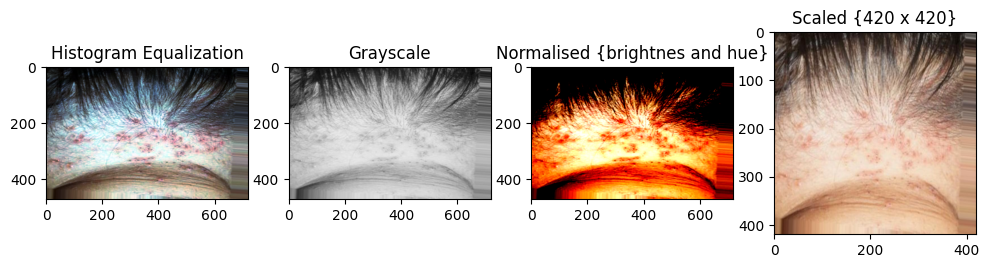

In [21]:
example = torchvision.io.read_image(train_imgs[100]) # reading an image directly into tensor image
tm_imgs = transform_images(example, (420, 420))

titles = ['Histogram Equalization', 'Grayscale', 'Normalised {brightnes and hue}', 'Scaled {420 x 420}']

fig, ax = plt.subplots(1, 4, figsize=(12, 10))
for i in range(len(tm_imgs)):
  ax[i].imshow(tm_imgs[i].permute(1, 2, 0).cpu()) # change the C, H, W arrangement to suit matplotlib
  ax[i].set_title(titles[i])

In [22]:
# pipe all transformations together
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomEqualize(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# get the data into a dataset using ImageFolder class
dataset = ImageFolder(train_root_path, transform=transform)

# load the data into a generator for use in models
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

#  CNN Model
class HairDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(HairDiseaseCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)  # Load a pre-trained ResNet model
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1])) # Remove the last fully connected layer of ResNet
        self.fc = nn.Linear(512, num_classes)    # Add a custom fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#  Train the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define device - use GPUs

num_classes = len(dataset.classes)  # Number of classes in  hair disease dataset
model = HairDiseaseCNN(num_classes).to(device) # move the model to the device

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # move data and labels to device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backpropagation
        optimizer.step()

        running_loss += loss.item() # sum losses for all iterations in an epoch

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training finished!")

# save the trained model
torch.save(model.state_dict(), "hair_disease_cnn.pth")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 293MB/s]


Epoch 1/10, Loss: 0.14162674825328092
Epoch 2/10, Loss: 0.05347516091327028
Epoch 3/10, Loss: 0.04764091941450412
Epoch 4/10, Loss: 0.028091165828203278
Epoch 5/10, Loss: 0.015757883448313807
Epoch 6/10, Loss: 0.02700375464877652
Epoch 7/10, Loss: 0.03519934683048632
Epoch 8/10, Loss: 0.02043141302659933
Epoch 9/10, Loss: 0.004765547444590084
Epoch 10/10, Loss: 0.012513431568708407
Training finished!


In [23]:
# extractor transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create the dataset and DataLoader without RandomEqualize
data_ext_loader = DataLoader(dataset, batch_size=32, shuffle=False)

model_extractor = HairDiseaseCNN(num_classes).to(device) # instatiate model
model_extractor.load_state_dict(torch.load("hair_disease_cnn.pth")) # load the learned parameters of the trained model

model_extractor.eval()

#  Feature Extraction
all_features = []
with torch.no_grad():
    for inputs, labels in data_ext_loader:
        inputs = inputs.to(device)
        features = model_extractor(inputs) # get all features from the model - except the last fully connected block
        all_features.append(features)

# Concatenate features from all batches into a single tensor
features_tensor = torch.cat(all_features)

# Now 'features_tensor' contains the extracted features from the model
print(features_tensor.shape)

torch.Size([9600, 2])


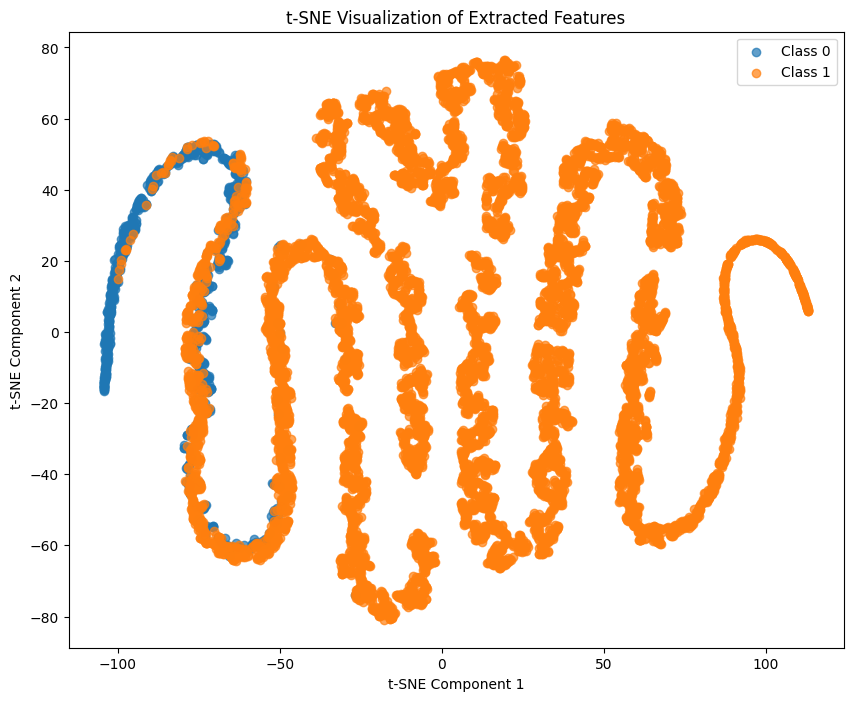

In [24]:
 # move the features from gpu
features_np = features_tensor.cpu().numpy()
features_np = (features_np - features_np.mean(axis=0)) / features_np.std(axis=0)

# Perform t-SNE on the features
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features_np)

class_labels = np.array([y for _, y in dataset])

# Create a scatter plot for each class
plt.figure(figsize=(10, 8))
for class_idx in np.unique(class_labels):
    class_mask = (class_labels == class_idx)
    plt.scatter(embedded_features[class_mask, 0], embedded_features[class_mask, 1], label=f"Class {class_idx}", alpha=0.7)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.title("t-SNE Visualization of Extracted Features")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming the train_imgs dataset is a list of image file paths or tensors

# Your code to read and transform the image, already provided
example = torchvision.io.read_image(train_imgs[1])
tm_imgs = transform_images(example)

# Titles for each of the transformed images
titles = ['Histogram Equalization', 'Grayscale', 'Normalized {brightness and hue}', 'Scaled {420 x 420}']

# Create a figure with subplots
fig, ax = plt.subplots(1, 4, figsize=(12, 10))

# Loop through each transformed image and its corresponding title
for i in range(len(tm_imgs)):
    # Show the image using matplotlib's imshow function
    ax[i].imshow(tm_imgs[i].permute(1, 2, 0).cpu())

    # Set the title for the corresponding image
    ax[i].set_title(titles[i])

# Display the images
plt.show()
